# Evaluate

This notebook evaluates the network trained previous notebooks and analyzes the results.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%cd ..
%load_ext autoreload
%autoreload 2

/home/imkbsz/workspace/eeg_analysis


In [2]:
# Load some packages
import os
from copy import deepcopy
import hydra
from omegaconf import OmegaConf
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pprint
import matplotlib.pyplot as plt

# custom package
from datasets.caueeg_script import build_dataset_for_train
import models
from train.evaluate import check_accuracy
from train.evaluate import check_accuracy_extended
from train.evaluate import check_accuracy_extended_debug
from train.evaluate import check_accuracy_multicrop
from train.evaluate import check_accuracy_multicrop_extended
from train.visualize import draw_roc_curve
from train.visualize import draw_confusion
from train.visualize import draw_error_table

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.11.0
cuda is available.


-----

## Load the configuration used during the train phase

In [4]:
model_name = 'kik2qsxk'
model_path = os.path.join('local/checkpoint_temp', model_name, 'last_checkpoint.pt')

ckpt = torch.load(model_path)
print(ckpt.keys())

dict_keys(['model_state', 'config', 'optimizer_state', 'scheduler_state'])


In [5]:
model_state = ckpt['model_state']
config = ckpt['config']
optimizer = ckpt['optimizer_state']
scheduler = ckpt['scheduler_state']

In [6]:
pprint.pprint(config, width=250)

{'EKG': 'X',
 '_target_': 'models.resnet_1d.ResNet1D',
 'activation': 'gelu',
 'age_mean': tensor([71.1643]),
 'age_std': tensor([9.9056]),
 'awgn': 0.05453868299322823,
 'awgn_age': 0.04157058779579202,
 'base_channels': 64,
 'base_lr': 0.0002108482517142911,
 'block': 'bottleneck',
 'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'conv_layers': [3, 4, 6, 3],
 'criterion': 'multi-bce',
 'crop_multiple': 4,
 'crop_timing_analysis': False,
 'cwd': '/home/imkbsz/workspace/eeg_analysis',
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/02_Curated_Data_220419/',
 'ddp': True,
 'ddp_size': 3,
 'device': 0,
 'draw_result': True,
 'dropout': 0.3737836926531366,
 'fc_stages': 5,
 'file_format': 'memmap',
 'in_channels': 19,
 'input_norm': 'dataset',
 'iterations': 72917,
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'cosine_decay_with_warmup_one_and_half',
 'mgn': 0.0055453965112194255,
 'm

-----

## Load the target model

In [7]:
# model = config['generator'](**config).to(device)
model = hydra.utils.instantiate(config).to(device)

if config.get('ddp', False):
    model_state_ddp = deepcopy(model_state)
    model_state = OrderedDict()
    for k, v in model_state_ddp.items():
        name = k[7:] # remove 'module.' of DataParallel/DistributedDataParallel
        model_state[name] = v
    model.load_state_dict(model_state)
else:
    model.load_state_dict(model_state)

-----

## Evaluate the model and analyze the performance by the crop timing

### Configurations

In [8]:
config = ckpt['config']

config['ddp'] = False
config['crop_timing_analysis'] = True
config['eval'] = True
config['device'] = device

repeat = round(200 / config['crop_multiple'])
print(repeat)

50


### Build Dataset

In [9]:
train_loader, val_loader, test_loader, multicrop_test_loader = build_dataset_for_train(config, verbose=True)

transform: Compose(
    EegRandomCrop(crop_length=1000, length_limit=10000000, multiple=4, latency=2000, return_timing=True)
    EegDropChannels(drop_index=[19, 20])
    EegToTensor()
)

----------------------------------------------------------------------------------------------------

transform_multicrop: Compose(
    EegRandomCrop(crop_length=1000, length_limit=10000000, multiple=8, latency=2000, return_timing=True)
    EegDropChannels(drop_index=[19, 20])
    EegToTensor()
)

----------------------------------------------------------------------------------------------------


task config:
{'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'task_description': 'Classification of [Normal], [MCI], and [Dementia] '
                     'symptoms.',
 'task_name': 'CAUEEG-task2 benchmark'}

 ---------------------------------------------------------------------------------------------------- 

train_dataset[0].keys():
d

### Train set

In [10]:
_ = check_accuracy_extended_debug(model, train_loader, 
                                  config['preprocess_test'], config, repeat=repeat)
train_acc = _[0]
train_score = _[1]
train_target = _[2]
train_confusion = _[3]
train_error_table = _[4]
train_crop_timing = _[5]

print(train_acc)

60.75326086956522


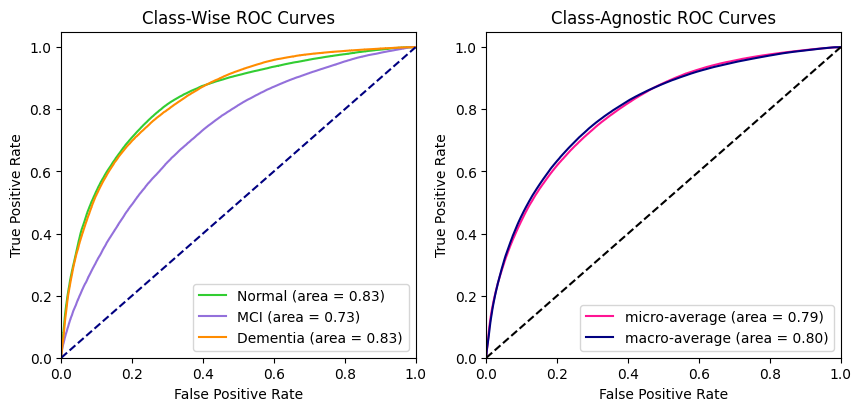

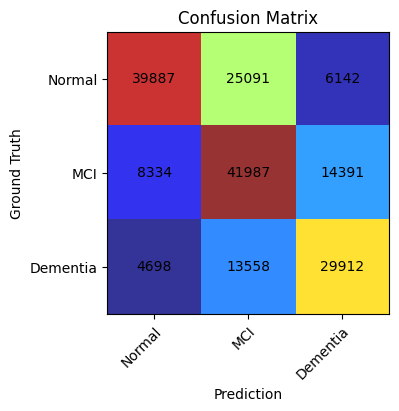

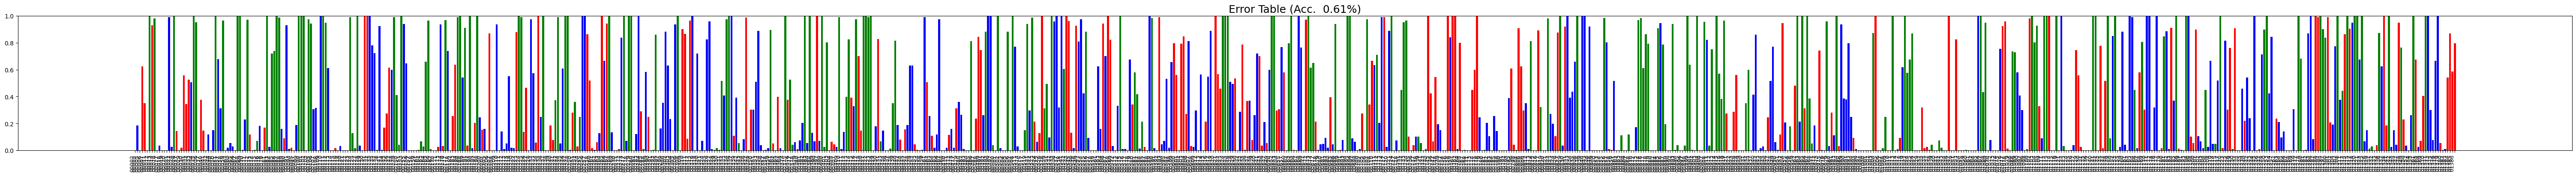

In [11]:
draw_roc_curve(train_score, train_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(train_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(train_error_table, use_wandb=False, fig_size=(60.0, 4.0))

### Validation set

In [12]:
_ = check_accuracy_extended_debug(model, val_loader, 
                                  config['preprocess_test'], config, repeat=repeat)
val_acc = _[0]
val_score = _[1]
val_target = _[2]
val_confusion = _[3]
val_error_table = _[4]
val_crop_timing = _[5]

print(val_acc)

56.62605042016807


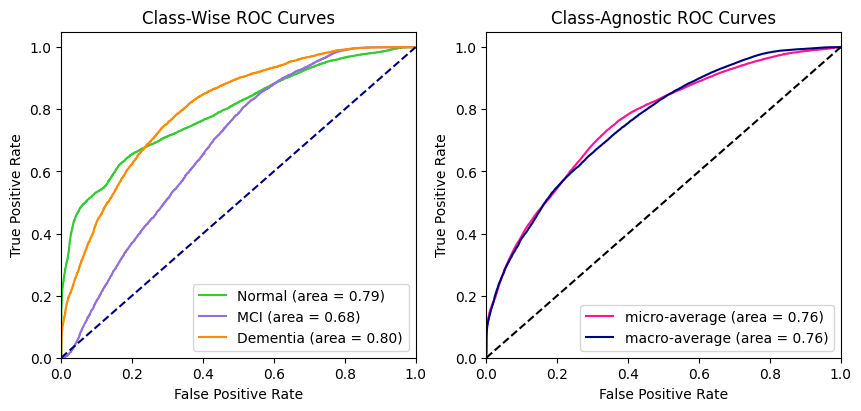

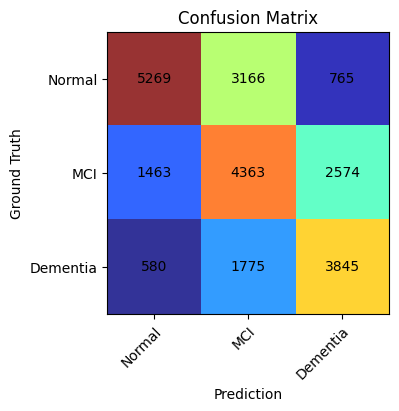

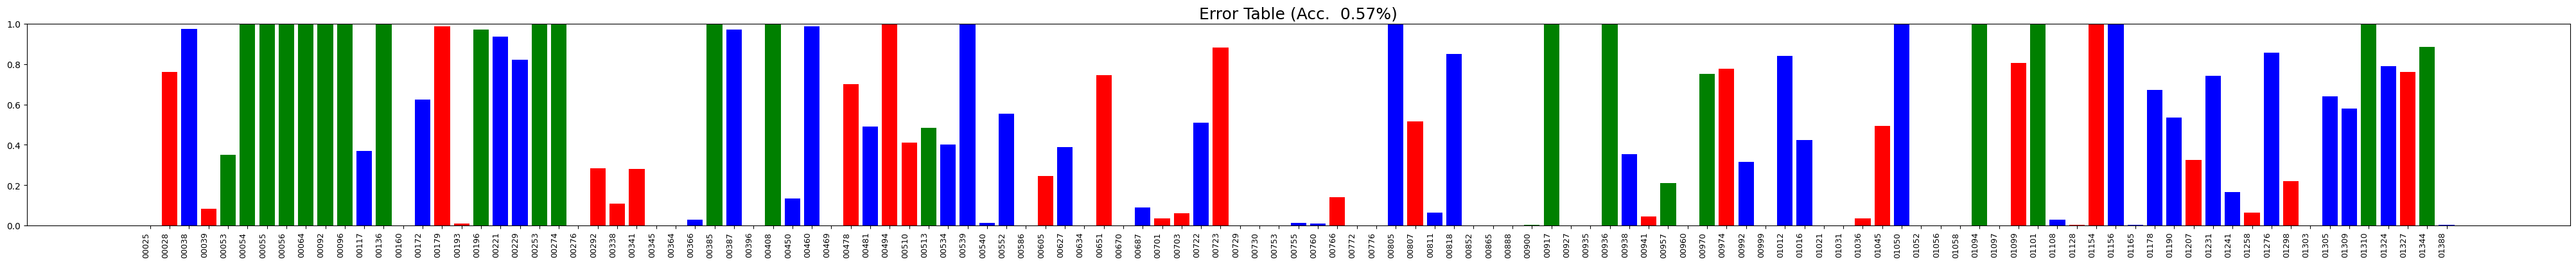

In [13]:
draw_roc_curve(val_score, val_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(val_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(val_error_table, use_wandb=False)

### Test set

In [14]:
_ = check_accuracy_extended_debug(model, test_loader, 
                                  config['preprocess_test'], config, repeat=repeat)
test_acc = _[0]
test_score = _[1]
test_target = _[2]
test_confusion = _[3]
test_error_table = _[4]
test_crop_timing = _[5]

print(test_acc)

57.20338983050848


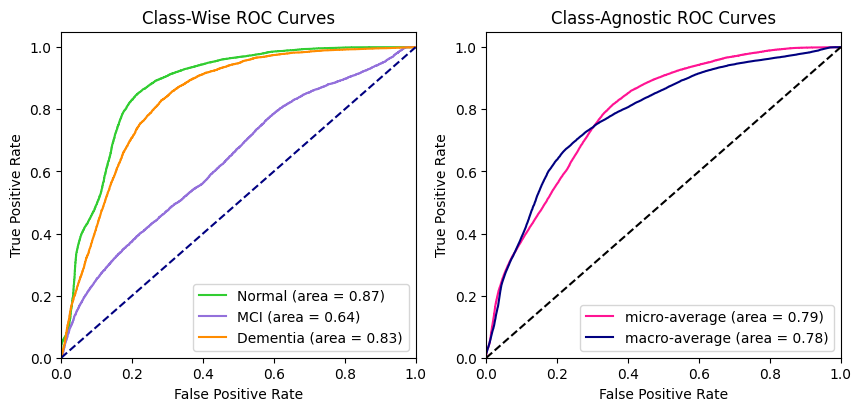

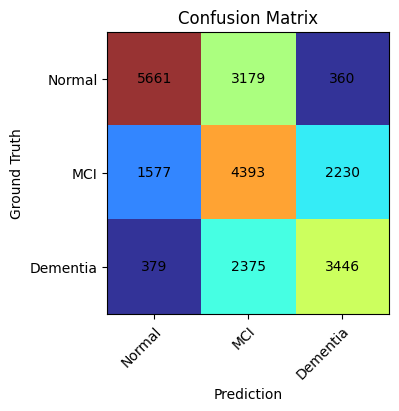

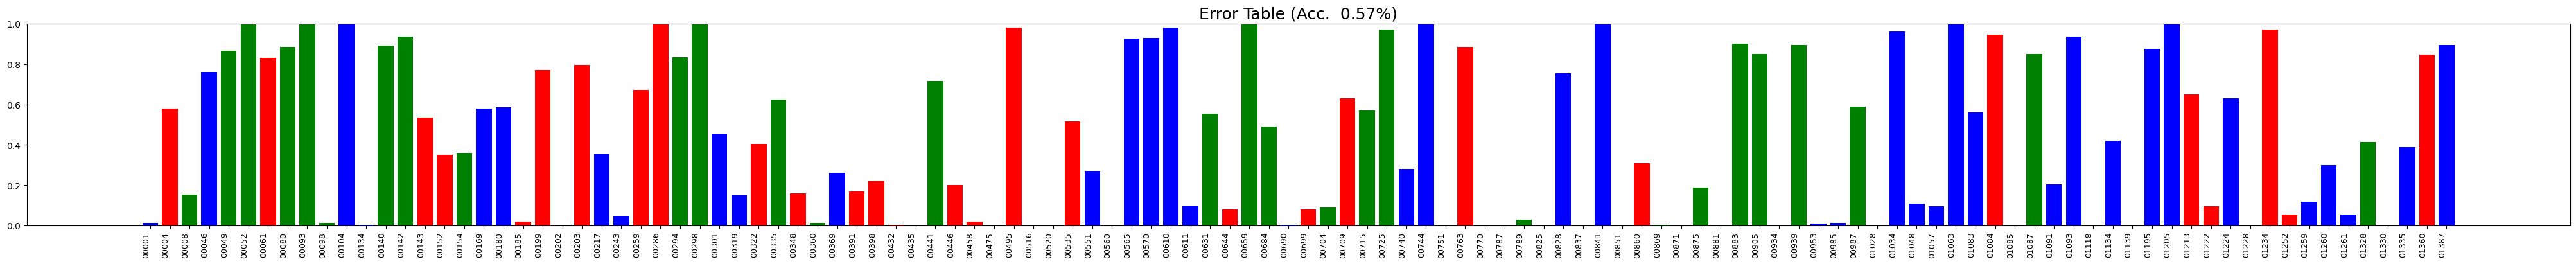

In [15]:
draw_roc_curve(test_score, test_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(test_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(test_error_table, use_wandb=False)

### Test set (with test-time augmentation)

In [16]:
_ = check_accuracy_multicrop_extended(model, multicrop_test_loader, 
                                      config['preprocess_test'], config, repeat=repeat)
multi_test_acc = _[0]
multi_test_score = _[1]
multi_test_target = _[2]
multi_test_confusion = _[3]
multi_test_error_table = _[4]

print(multi_test_acc)

58.355932203389834


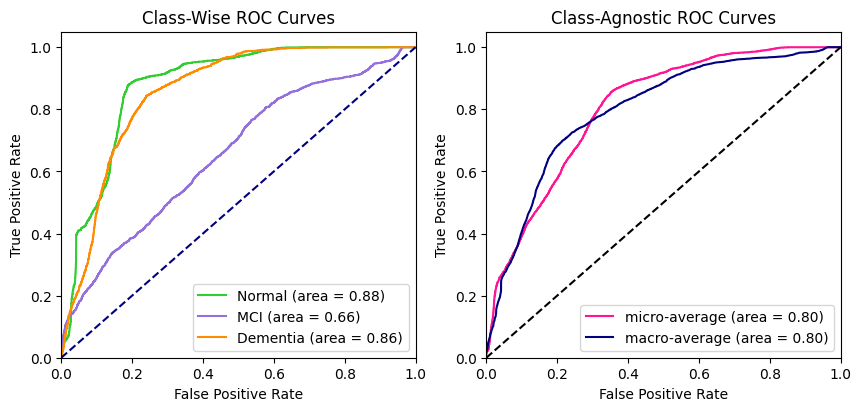

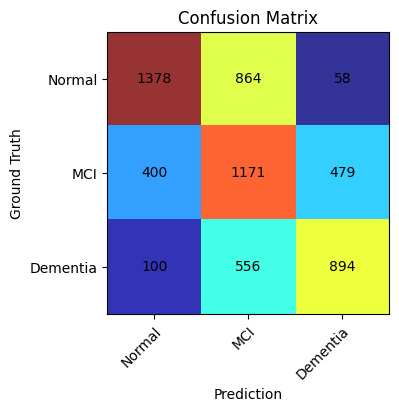

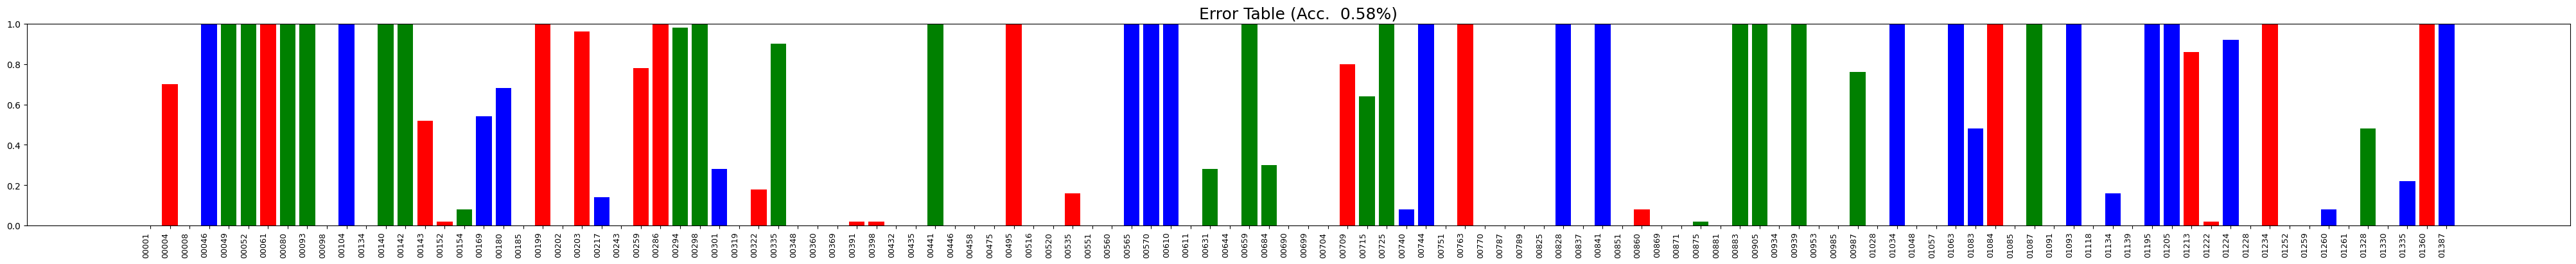

In [17]:
draw_roc_curve(multi_test_score, multi_test_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(multi_test_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(multi_test_error_table, use_wandb=False)

### Examine whether the model has a bias related to the cropping starting time

In [18]:
train_pos = []
train_neg = []

for k, v in train_crop_timing.items():
    for i in range(v.get('correct', 0)):
        train_pos.append(k)
    for i in range(v.get('incorrect', 0)):
        train_neg.append(k)

##

val_pos = []
val_neg = []

for k, v in val_crop_timing.items():
    for i in range(v.get('correct', 0)):
        val_pos.append(k)
    for i in range(v.get('incorrect', 0)):
        val_neg.append(k)

##

test_pos = []
test_neg = []

for k, v in test_crop_timing.items():
    for i in range(v.get('correct', 0)):
        test_pos.append(k)
    for i in range(v.get('incorrect', 0)):
        test_neg.append(k)

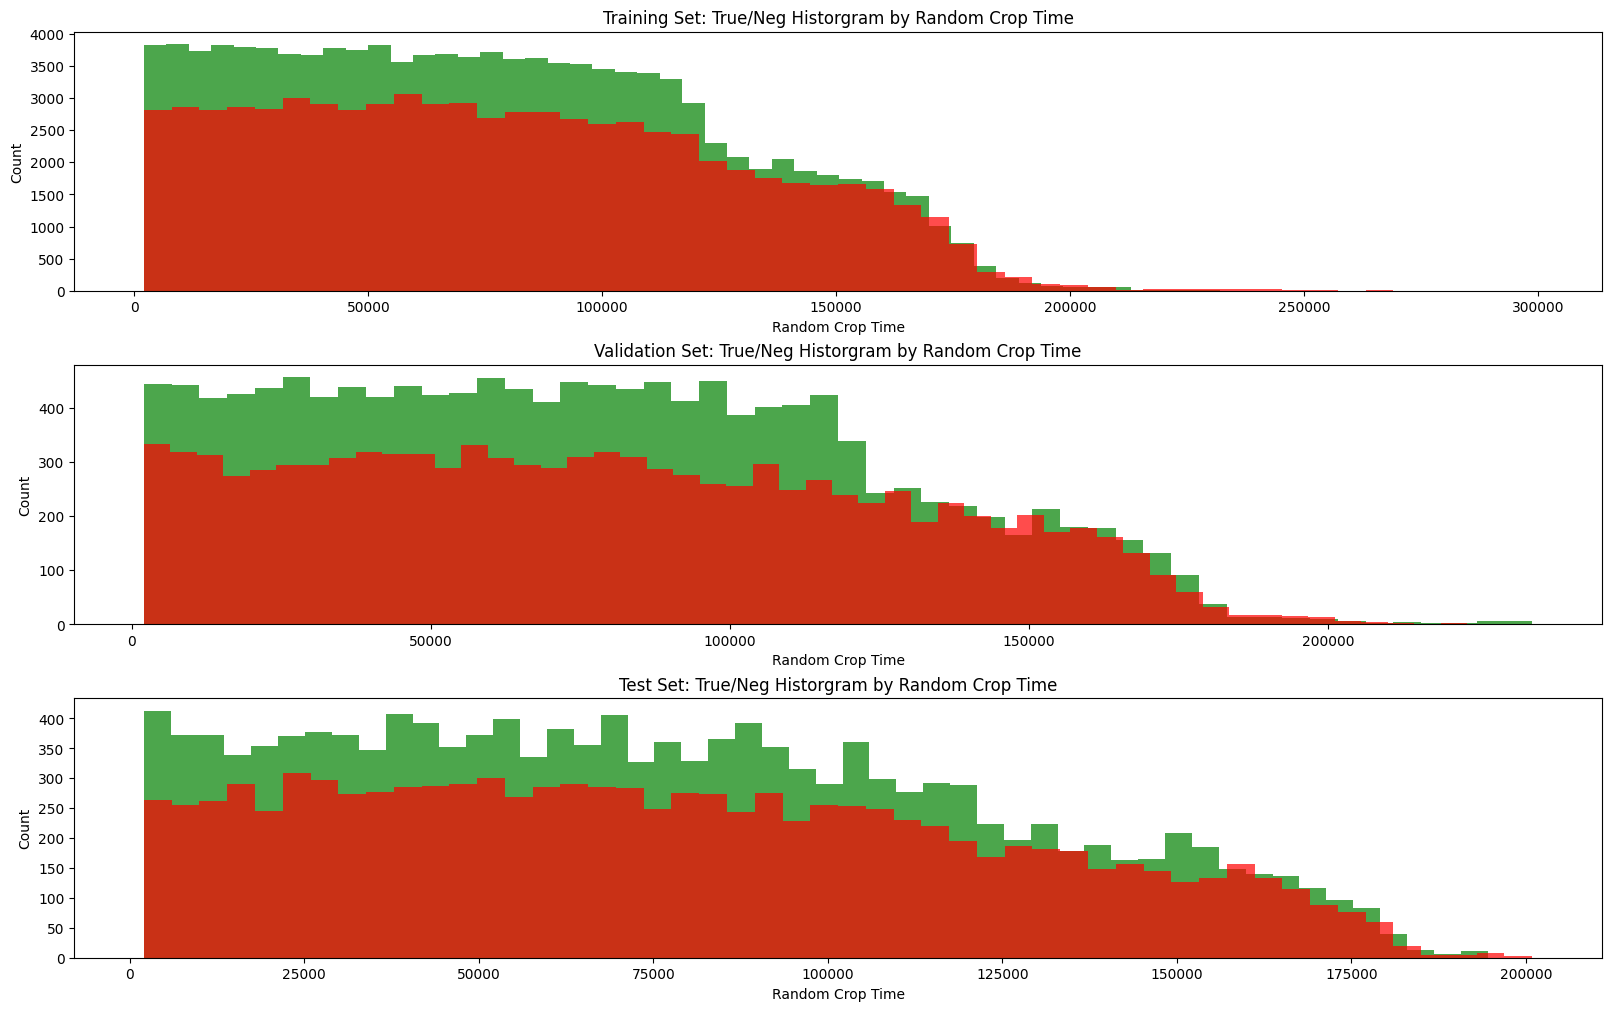

In [19]:
fig = plt.figure(num=1, clear=True, figsize=(16, 10), constrained_layout=True)
n_bins = 50
density = False

ax = fig.add_subplot(3, 1, 1)
ax.hist(train_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(train_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Training Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

ax = fig.add_subplot(3, 1, 2)
ax.hist(val_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(val_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Validation Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

ax = fig.add_subplot(3, 1, 3)
ax.hist(test_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(test_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Test Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

plt.show()
fig.clear()
plt.close(fig)

-----

## Evaluate the model with length limit

### Configurations

In [20]:
config = ckpt['config']

config['crop_timing_analysis'] = False
config['signal_length_limit'] = 200 * 60 * 7  # 7 minutes
config['eval'] = True
config['device'] = device

repeat = round(50 / config['crop_multiple'])

train_loader, val_loader, test_loader, multi_test_loader = build_dataset_for_train(config, verbose=False)

In [21]:
# train
train_acc = check_accuracy(model, train_loader, 
                           config['preprocess_test'], config, repeat=repeat)
val_acc = check_accuracy(model, val_loader, 
                         config['preprocess_test'], config, repeat=repeat)
test_acc = check_accuracy(model, test_loader, 
                          config['preprocess_test'], config, repeat=repeat)
multi_test_acc = check_accuracy_multicrop(model, multi_test_loader, 
                                          config['preprocess_test'], config, repeat=repeat)

print(train_acc, val_acc, test_acc, multi_test_acc)

60.905797101449274 56.127450980392155 57.3975988700565 57.76836158192091
